In [1]:
"""
Vector Autoregression and other time series methods.
"""
import os
import random

import itertools
import numpy as np
import pandas as pd

from pprint import pprint

from datetime import datetime

from tqdm import tqdm

import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

from data_feed import direct_feed
from training_utils import directional_accuracy, mape

plt.style.use("grayscale")

plt.rcParams["figure.figsize"] = (9, 3)

In [2]:
data_src = "../data/ready_to_use/feature_target_2020-04-05-14:13:42.csv"
rpna_dir = "../data/ready_to_use/rpna_r0_all.csv"
figure_dir = "../figures/tsa_figures/"

In [3]:
df_news = pd.read_csv(
    rpna_dir,
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)

In [4]:
# ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
X_train, X_test, y_train, y_test = direct_feed(
    src=data_src,
    test_start=pd.to_datetime("2019-01-01"),
    day=None,
    return_array=False
)
print(f"X_train @ {X_train.shape}")
print(f"y_train @ {y_train.shape}")
print(f"X_test @ {X_test.shape}")
print(f"y_test @ {y_test.shape}")
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

Dropped rows involving Nan: 2
X_train @ (4746, 416)
y_train @ (4746,)
X_test @ (186, 416)
y_test @ (186,)


In [5]:
df_train = pd.DataFrame(y_train.copy())
df_test = pd.DataFrame(y_test.copy())

# Basic

In [6]:
y_train = y_train.values
y_test = y_test.values

In [7]:
take_diff = lambda x: np.diff(x)[1:]

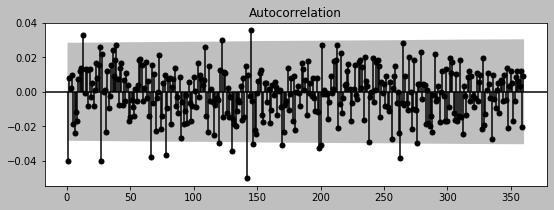

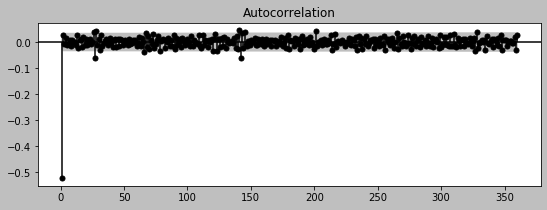

In [8]:
sm.tsa.graphics.plot_acf(y_train, zero=False, lags=360)
sm.tsa.graphics.plot_acf(take_diff(y_train), zero=False, lags=360)
plt.show()

In [9]:
print(f"Baseline: {np.mean(y_train ** 2)}")
print(f"Baseline: {np.mean(y_test ** 2)}")

Baseline: 4.6552044916665904
Baseline: 4.056767346330822


# ARIMA Hyperparameter Tuning

In [29]:
## Grid Searching for Parameters
# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
p = q = [0, 1, 2, 3, 4, 5]
d = [0, 1, 2]
pdq_config = list(itertools.product(p, d, q))

random.shuffle(pdq_config)

print(f"Total: {len(pdq_config)} configurations.")

Total: 72 configurations.


In [35]:
LOG_DIR = "../model_selection_results/arima_results.csv"

In [36]:
! touch LOG_DIR

In [37]:
candidates = list()

with open(LOG_DIR, "w") as log:
    log.write("p,d,q,aic\n")
    for i, param in tqdm(enumerate(pdq_config)):
#         print(param)
        model = ARIMA(y_train, order=param)
        results = model.fit()
        candidates.append({
            "pdq": param,
            "aic":results.aic
        })
        log.write(
            ",".join(str(x) for x in param) + "," + str(results.aic) + "\n"
        )





0it [00:00, ?it/s]



1it [00:00,  1.96it/s]



2it [00:01,  1.82it/s]



3it [00:03,  1.18s/it]



4it [00:04,  1.02it/s]



5it [00:05,  1.10it/s]



7it [00:09,  1.24s/it]/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




8it [00:22,  4.97s/it]/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)




9it [00:51, 12.03s/it]



11it [00:53,  8.76s/it]



12it [00:53,  6.21s/it]



13it [00:57,  5.54s/it]



14it [01:02,  5.41s/it]



15i

In [51]:
candidates.sort(key=lambda x: x["aic"])
print("Total num. of configs: ", len(candidates))
pprint(candidates[:5])
best_pdq = candidates[0]["pdq"]
print("Best parameter: ", best_pdq)

Total num. of configs:  72
[{'aic': 20759.69174489365, 'pdq': (5, 0, 5)},
 {'aic': 20760.17268221306, 'pdq': (4, 0, 3)},
 {'aic': 20761.413796780696, 'pdq': (5, 0, 4)},
 {'aic': 20762.210899391986, 'pdq': (3, 0, 2)},
 {'aic': 20763.798486848853, 'pdq': (3, 0, 3)}]
Best parameter:  (5, 0, 5)


# ARIMA: Result

In [22]:
ORDER = (5,0,4)

In [23]:
model = ARIMA(y_train, order=ORDER)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# residuals.plot(kind='kde')
# plt.show()
print(f"Train MSE: {np.mean(residuals ** 2)}")
print(residuals.describe())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4746
Model:                     ARMA(5, 4)   Log Likelihood              -10369.707
Method:                       css-mle   S.D. of innovations              2.151
Date:                Sun, 12 Apr 2020   AIC                          20761.414
Time:                        20:22:56   BIC                          20832.529
Sample:                             0   HQIC                         20786.405
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0250      0.030      0.845      0.398      -0.033       0.083
ar.L1.y        0.8309      0.047     17.806      0.000       0.739       0.922
ar.L2.y       -0.5655      0.032    -17.873      0.0

In [25]:
history = [x for x in y_train]
predictions = list()
for t in range(len(y_test)):
    model = ARIMA(history, order=ORDER)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print("predicted=%f, expected=%f" % (yhat, obs))

predicted=0.063404, expected=0.507353
predicted=0.082801, expected=1.308610
predicted=0.055412, expected=1.774445
predicted=0.049410, expected=0.354059
predicted=0.009777, expected=2.677728
predicted=-0.145073, expected=5.130338
predicted=-0.217791, expected=0.439729
predicted=-0.064788, expected=-1.887212
predicted=0.000761, expected=-0.740407
predicted=-0.034778, expected=2.918629
predicted=-0.246920, expected=0.539085


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.110341, expected=-0.481187
predicted=0.118731, expected=3.357994
predicted=-0.036978, expected=-0.475577
predicted=0.100137, expected=-0.285633
predicted=0.172059, expected=0.948954
predicted=0.082978, expected=1.108305
predicted=-0.090573, expected=-1.101506
predicted=0.043098, expected=2.441472
predicted=-0.088911, expected=2.070004
predicted=-0.200302, expected=-0.629515
predicted=-0.024881, expected=2.657538
predicted=-0.027735, expected=-0.436926
predicted=-0.000474, expected=-1.625752
predicted=0.038950, expected=0.464555
predicted=0.110631, expected=-2.363644
predicted=0.107276, expected=0.132790
predicted=-0.071631, expected=-0.202828
predicted=0.142042, expected=1.345099
predicted=0.007017, expected=1.308675
predicted=-0.068710, expected=1.034747
predicted=0.121647, expected=2.145927
predicted=0.037274, expected=0.241721
predicted=-0.057833, expected=1.380309
predicted=-0.010029, expected=0.087835
predicted=0.043077, expected=0.105300
predicted=-0.167980, expected

/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianI

predicted=0.159215, expected=-0.385619
predicted=0.147806, expected=-3.186838
predicted=0.061255, expected=-1.650029


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.054670, expected=-2.545396
predicted=-0.053132, expected=0.615387
predicted=-0.160508, expected=0.269567
predicted=-0.128438, expected=1.262800
predicted=0.102262, expected=-1.209119
predicted=0.348629, expected=-0.035785
predicted=0.105663, expected=0.285919
predicted=0.225951, expected=0.478350
predicted=0.211568, expected=2.071621
predicted=-0.080776, expected=0.840701
predicted=-0.081788, expected=-8.724439
predicted=0.305851, expected=3.714634


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.311899, expected=-0.628607


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-0.038917, expected=-1.903411
predicted=0.039710, expected=-4.698210
predicted=0.264557, expected=2.814915
predicted=-0.086743, expected=3.383184
predicted=0.095849, expected=0.347384


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.085413, expected=3.695859
predicted=0.068189, expected=-3.369002
predicted=0.312876, expected=-1.185388
predicted=0.085695, expected=0.585332
predicted=-0.195612, expected=0.846359
predicted=-0.339129, expected=-0.106743


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.144147, expected=-0.947874


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-0.072830, expected=-0.576682
predicted=-0.088876, expected=-2.285083


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.002285, expected=-0.334513
predicted=0.218684, expected=2.672231
predicted=0.065943, expected=1.390542


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.128442, expected=1.618820
predicted=0.253529, expected=-2.863987
predicted=0.237646, expected=-0.532228
predicted=-0.045605, expected=4.195658


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-0.142561, expected=0.195469


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.043897, expected=0.212804
predicted=-0.134611, expected=0.833887


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.183393, expected=-0.885038
predicted=-0.029779, expected=-3.025976
predicted=0.096964, expected=-0.956772
predicted=0.182800, expected=-0.673403


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.182810, expected=4.725359
predicted=-0.088911, expected=-6.278623
predicted=0.544470, expected=-1.822102
predicted=0.224879, expected=0.000000


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.017684, expected=-0.465077


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.014556, expected=0.440220


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-0.101148, expected=-2.536587
predicted=0.022007, expected=-1.478900


/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.074481, expected=-0.248624
predicted=0.064526, expected=-0.516981


In [26]:
f = lambda x: x.values.squeeze()

Order=(5, 0, 4)
Test MSE: 4.073
Test MAPE: 107.678
Test DA: 50.567%


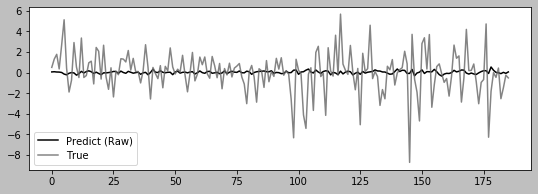

In [27]:
print(f"Order={ORDER}")

predictions = np.array(predictions)
amp_pred = predictions / np.std(predictions) * np.std(y_train)

test_mse = np.mean((y_test - predictions) ** 2)
test_mape = mape(y_test, predictions)
test_da = directional_accuracy(y_test, predictions)
print(f"Test MSE: {test_mse:.3f}")
print(f"Test MAPE: {test_mape:.3f}")
print(f"Test DA: {test_da*100:.3f}%")

# plot
plt.plot(predictions, label="Predict (Raw)", alpha=1.0)
plt.plot(y_test, label="True", alpha=0.8)
# plt.plot(amp_predictions, label="Predict (Amp)")
plt.legend()
plt.savefig(figure_dir + "arima_505.png", dpi=300, bbox_inches="tight")
plt.show()

# Seasonal ARIMA

In [246]:
model = SARIMAX(y_train, order=(7,1,0), seasonal_order=(4,1,0,14))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
print(f"Train MSE: {np.mean(residuals ** 2)}")
print(residuals.describe())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 4746
Model:             SARIMAX(7, 1, 0)x(4, 1, 0, 14)   Log Likelihood              -11085.905
Date:                            Fri, 10 Apr 2020   AIC                          22195.810
Time:                                    18:27:42   BIC                          22273.352
Sample:                                         0   HQIC                         22223.063
                                           - 4746                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9036      0.010    -94.897      0.000      -0.922      -0.885
ar.L2         -0.7603      0.014   

In [249]:
history = [x for x in y_train]
predictions = list()
for t in range(len(y_test)):
    SARIMAX(y_train, order=(5,1,0), seasonal_order=(2,1,0,14))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print("predicted=%f, expected=%f" % (yhat, obs))

predicted=-0.151009, expected=0.507353
predicted=-0.151009, expected=1.308610
predicted=-0.151009, expected=1.774445
predicted=-0.151009, expected=0.354059
predicted=-0.151009, expected=2.677728
predicted=-0.151009, expected=5.130338
predicted=-0.151009, expected=0.439729
predicted=-0.151009, expected=-1.887212
predicted=-0.151009, expected=-0.740407
predicted=-0.151009, expected=2.918629
predicted=-0.151009, expected=0.539085
predicted=-0.151009, expected=-0.481187
predicted=-0.151009, expected=3.357994
predicted=-0.151009, expected=-0.475577
predicted=-0.151009, expected=-0.285633
predicted=-0.151009, expected=0.948954
predicted=-0.151009, expected=1.108305
predicted=-0.151009, expected=-1.101506
predicted=-0.151009, expected=2.441472
predicted=-0.151009, expected=2.070004
predicted=-0.151009, expected=-0.629515
predicted=-0.151009, expected=2.657538
predicted=-0.151009, expected=-0.436926
predicted=-0.151009, expected=-1.625752
predicted=-0.151009, expected=0.464555
predicted=-0.151

KeyboardInterrupt: 

In [13]:
lenppredictionsctions

NameError: name 'pred' is not defined

In [ ]:
predictions = np.array(predictions)
amp_pred = predictions / np.std(predictions) * np.std(y_train)

test_mse = np.mean((y_test - predictions) ** 2)
test_mape = mape(y_test, predictions)
test_da = directional_accuracy(y_test, predictions)
print(f"Test MSE: {test_mse:.3f}")
print(f"Test MAPE: {test_mape:.3f}")
print(f"Test DA: {test_da:.3f}")

# plot
plt.plot(y_test, label="True")
plt.plot(predictions, color="red", label="Predict (Raw)")
plt.plot(amp_predictions, color="orange", label="Predict (Amp)")
plt.legend()
plt.show()

# VAR

In [130]:
index_train = df_news.index.intersection(df_train.index)
rpna_train = df_news.loc[index_train]
df_train = df_train.loc[index_train]
data_all = pd.concat([rpna_train, df_train], axis=1)

In [176]:
data_all.head()

,ESS_MEAN,ESS_TOTAL,WESS_MEAN,WESS_TOTAL,NUM_EVENTS,NUM_POSITIVE_ESS,NUM_NEGATIVE_ESS,NUM_NEUTRAL_ESS,NUM_POSITIVE_WESS,NUM_NEGATIVE_WESS,NUM_NEUTRAL_WESS,TARGET
2000-02-07,-6.000000,-144.0,-1.008333,-24.20,24.0,7.0,15.0,2.0,7.0,9.0,8.0,-0.315405
2000-02-08,-10.857142,-152.0,-3.396429,-47.55,14.0,3.0,11.0,0.0,3.0,4.0,7.0,-1.240051
2000-02-09,-15.000000,-15.0,-1.950000,-1.95,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.325686
2000-02-10,3.000000,27.0,2.026667,18.24,9.0,4.0,3.0,2.0,4.0,3.0,2.0,2.680573
2000-02-11,9.222222,83.0,0.155556,1.40,9.0,7.0,2.0,0.0,4.0,2.0,3.0,0.067797


In [177]:
independent_var = "ESS_TOTAL"
data = data_all[[independent_var, "TARGET"]].copy()

In [228]:
data = data_all[["ESS_MEAN", "WESS_MEAN", "TARGET"]]

In [229]:
model = VAR(data)
results = model.fit(maxlags=100, ic="aic")
results.summary()

/Users/tianyudu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Apr, 2020
Time:                     18:06:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    8.29477
Nobs:                     4717.00    HQIC:                   8.21219
Log likelihood:          -39249.3    FPE:                    3524.26
AIC:                      8.16742    Det(Omega_mle):         3455.68
--------------------------------------------------------------------
Results for equation ESS_MEAN
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.327058         0.142156            2.301           0.021
L1.ESS_MEAN           0.082912         0.029366            2.823           0.005
L1.WESS_MEAN          0.032113         0.044537          

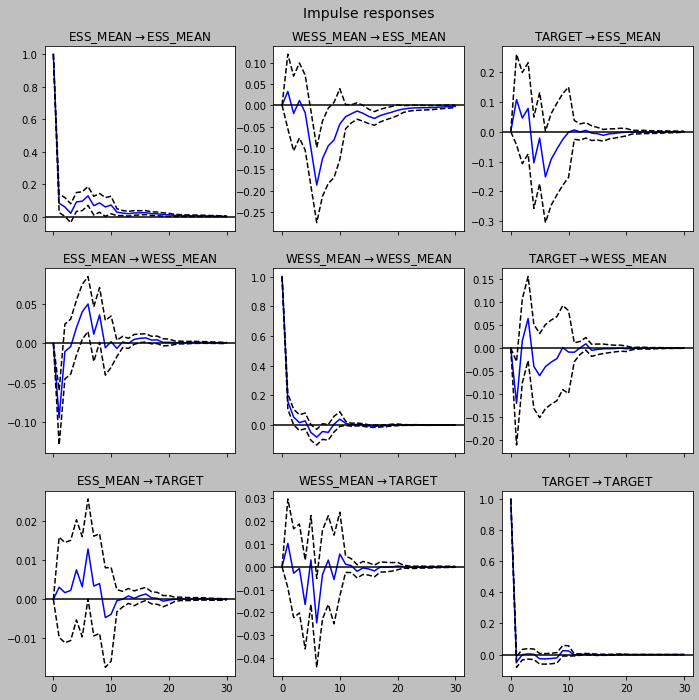

In [241]:
irf = results.irf(30)
# irf.plot(impulse=independent_var, response="TARGET")
irf.plot(orth=False)
plt.savefig(figure_dir + f"irf.png", dpi=300, bbox_inches="tight")
plt.show()

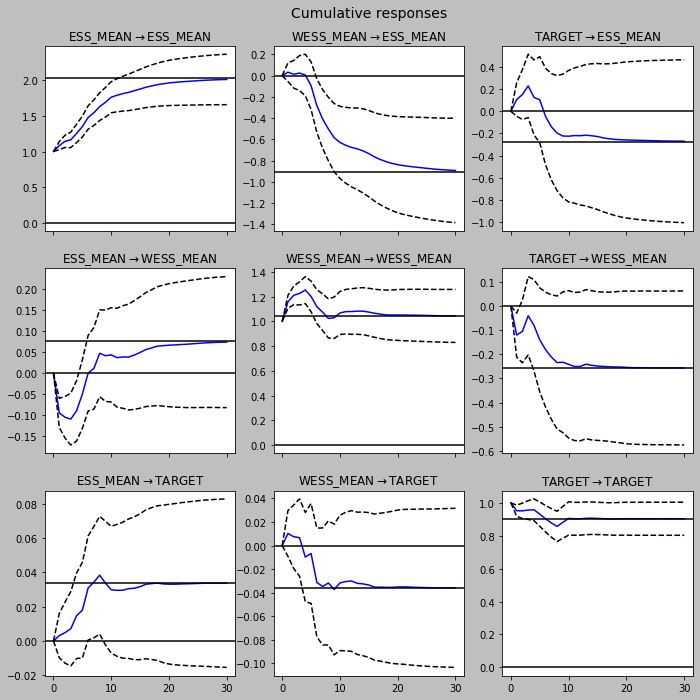

In [242]:
irf.plot_cum_effects(orth=False)
plt.savefig(figure_dir + f"irf_cum.png", dpi=300, bbox_inches="tight")
plt.show()